# The beginning of a journey...

The purpose of this notebook is to analyze my "adventure" at finding my first job in a data analyst/ data scientist/ ML engineer position. The notebook is divided into 3 main sections:

- Location
- Time
- Position

Where in each section will be specified the questions to answer. Hope that you enjoy it :D.

In [1]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd, MonthBegin
import geopandas as gpd
import numpy as np
import re
import os

import folium
from branca.element import Template, MacroElement
from bottle import template as Temp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
import plotly.graph_objects as go
import seaborn as sns

We will start by reading the data and cleaning it so that it is ready to be worked

In [2]:
data = pd.read_csv('./data/jobs.csv')

data.rename(columns={data.columns[0]:'Company'}, inplace=True)

In [3]:
data = data.iloc[:data.shape[0]-2].copy() # Remove last 2 rows
data.replace('-', np.nan, inplace=True) # Assume '-' as a missing value
data.drop(index=data[data.isna().all(axis=1)].index, axis=1, inplace=True) # Drop rows with only missing values

# Reformat so 'Day Sent' & 'Reply Date' to be datetime objects
data['Day Sent'] = pd.to_datetime(data['Day Sent'], format=r'%d-%m-%Y')
data['Reply Date'] = pd.to_datetime(data['Reply Date'], format=r'%d-%m-%Y')

data.head()

,Company,City,Country,Link,Day Sent,Position,Notes,Status,Reply Date
0,FRISS,Utrecht,Netherlands,here,2021-10-09,ML Engineer,NaN,Denied,2021-10-13
1,Unilever,Rotterdam,Netherlands,here,2021-10-10,Data Scientist,NaN,Not Responded,NaT
2,Philip Morris Interntional,Amsterdam,Netherlands,here,2021-10-10,Data Scientist,NaN,Denied,NaT
3,Nike,Amsterdam,Netherlands,here,2021-10-10,Data Analyst,NaN,Denied,2021-10-19
4,Vinted,Amsterdam,Netherlands,here,2021-10-10,Data Analyst,NaN,Denied,2021-11-12


In [4]:
if not os.path.exists("./images"):
    os.mkdir("./images")

## Start of the Analysis

Know we are ready for the fun part :D, and we will start to study about the location of the vacancies...

## Location

As the title suggests, this section will be answer questions about the location of the positions I have been applying to, and many more... In specific, I will try to answer these questions:

- In which countries am I applying
- Which country seems to reply the most and least (even if it is to say no :c)
- Which country has the best success rate (where I was able to get at least 1 interview).


In [5]:
def prepGeoFile(geofile, df):
    geofile['Amount'] = 'None'

    geofile.loc[geofile['name']=='Portugal', 'Amount'] = 'Base'

    for country in df['Country'].unique():
        geofile.loc[geofile['name']==country, 'Amount'] = df.loc[df['Country'] == country].shape[0]

    return geofile

def rgb_to_hex(rgb):
    return r'#%02x%02x%02x' % tuple((np.array(rgb)*255).astype('int16'))

def create_palette(df, palette='viridis'):
    palette_colors = sns.color_palette(palette, df['Amount'].nunique()-2)
    palette_colors = list(map(lambda x: rgb_to_hex(x), palette_colors))

    values = df['Amount'].astype('str').str.extractall('(\d+)').unstack().sum(axis=1).astype(int).sort_values()

    return dict(zip(values, palette_colors))

def style_function(feature, palette, fillOpacity=0.5):
    cv_sent = feature['properties']['Amount']
    
    if cv_sent == 'Base':
        fillColor = r'#FF0000'
    elif cv_sent == 'None':
        fillColor = r'#000000'
    else:
        fillColor = palette[cv_sent]

    return {
        'fillOpacity': fillOpacity,
        'weight': 0.5,
        'fillColor': fillColor
    }

def add_categorical_legend(folium_map, template, info):
    with open(template, 'r') as f:
        legend_template = f.read()

    legend_template = Temp(legend_template, info)

    macro = MacroElement()
    macro._template = Template(legend_template)
    folium_map.get_root().add_child(macro)

    return folium_map

In [6]:
country_df = gpd.read_file(r'./data/geoData/europe.geojson')
country_df = prepGeoFile(country_df, data)

palette = create_palette(country_df)

m = folium.Map(location=[53, 9], zoom_start=3)

gjson = folium.GeoJson(
    country_df,
    style_function= lambda x: style_function(x, palette=palette),
    highlight_function=lambda x: {"weight": 3},
    tooltip=folium.features.GeoJsonTooltip(
        fields= ['name', 'Amount'],
        aliases=["Country", 'CV sent'],
        sticky=True,
        opacity=0.9,
        direction="bottom",
    ),
).add_to(m)

m = add_categorical_legend(
    folium_map=m,
    template=r'./templates/map_legend_template.tp',
    info={
        'title':'CV Sent', 
        'legend':[('Base', '#FF0000')] + list(palette.items()), 
        'fillOpacity':0.5,
    }
)

m.save("./images/map.html")

m

Now it will be shown every outcome for each country, in order to conclude which one has the highest interview rate. <br> For that, it will be shown a Sankey plot. 

In [7]:
def prepCountData(df, feature):
    groupbyData = df.groupby([feature, 'Status']).size().reset_index()
    groupbyData.rename(columns={groupbyData.columns[-1]:'Amount'}, inplace=True)

    total = groupbyData['Amount'].sum()
    sankeyDict = {f'Total:{total}' : total}

    for value in groupbyData[feature].unique():
        value_data = groupbyData.loc[groupbyData[feature] == value, ]
        nr_interviews = 0

        value_amount = value_data['Amount'].values.sum()
        value_responded_amount = value_data.loc[value_data['Status'] != 'Not Responded', 'Amount'].values.sum()

        sankeyDict[f'{value}:{value_amount}'] = value_amount
        sankeyDict[f'{value}_Replied:{value_responded_amount}'] = value_responded_amount

        for status in value_data['Status'].unique():
            amount = value_data.loc[value_data['Status'] == status, 'Amount'].values[0]

            if status != 'Not Responded':
                if re.search('[1-9]', status): # if it has a number, then it was a interview
                    nr_interviews += amount
                    key = f'{value}_Replied_Interviews_{status}:{amount}'
                else:
                    key = f'{value}_Replied_{status}:{amount}'
            else:
                key = f'{value}_{status}:{amount}'

            sankeyDict[key] = amount

        if nr_interviews > 0 :
            sankeyDict[f'{value}_Replied_Interviews:{nr_interviews}'] = nr_interviews

    sankeyDict = list(sankeyDict.items())
    sankeyDict.sort(key=lambda x: x[0].count('_'))

    return dict(sankeyDict)

def prepSourceArray(sankeyData):
    source = []

    keys = list(sankeyData.keys())

    for i, key in enumerate(keys):
        nr_ = key.count('_')

        if nr_ == 0:
            source.append(0)
            continue

        for j, key_compare in enumerate(list(keys)[:i]):
            if re.search('({tag})'.format(tag=key_compare.split(':')[0]), key) and key_compare.count('_') == nr_ -1:
                source.append(j)
                continue

    return np.array(source)

def prepSankeyData(df, feature, palette='viridis'):
    countData = prepCountData(df, feature)

    palette_colors = sns.color_palette(palette, len(countData))
    palette_colors = np.array(list(map(lambda x: rgb_to_hex(x), palette_colors)))

    #label = np.array(list(countData.keys()))
    label = np.array([key.split('_')[-1] for key in countData.keys()])
    values = np.array(list(countData.values()))
    source = prepSourceArray(countData) 
    target = np.arange(0, len(countData))
    target[0] = -1
    
    return {'label':label, 'source':source, 'target':target, 'values':values, 'palette':palette_colors}

In [8]:
sankeyData = prepSankeyData(data, 'Country')

nodeX = [0,  0.25, 0.25, 0.25, 0.25,  0.50,  0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50,  0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 1.00, 1.0]
nodeY = [0, -0.10, 0.25, 0.75, 1.05, -0.15, -0.05, 0.20, 0.35, 0.70, 0.85, 1.05, 1.15, -0.15, 0.25, 0.15, 0.05, 0.75, 0.65, 1.05, -0.01, 0.1]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label = sankeyData['label'],
      color = sankeyData['palette'],
      x = nodeX,
      y = nodeY,
    ),
    # Add links
    link = dict(
      source = sankeyData['source'],
      target = sankeyData['target'],
      value = sankeyData['values'],
      label = sankeyData['label'],
      color = sankeyData['palette'],
))])

fig.update_layout(font_size=10)

fig.write_image('./images/country_sankey.png')

fig.show()

## Time

In this section, it will be answered the following questions:

- When did I start sending CV's
- Which day have I sent the most CV's
- Average time to wait for a reply

In [9]:
cvSentPerDay = pd.DataFrame(
    {
        'Day':pd.date_range(data['Day Sent'].min() + MonthBegin(-1), data['Day Sent'].max() + MonthEnd(0)),
        'Sent':0,
        'Replies':0,
    }
)

# Count the CV Sent per day
for day in data['Day Sent'].unique():
    count = data.loc[data['Day Sent'] == day].shape[0]

    cvSentPerDay.loc[cvSentPerDay['Day'] == day, 'Sent'] = count

# Count the replies received per day
for day in data['Reply Date'].unique():
    count = data.loc[data['Reply Date'] == day].shape[0]

    cvSentPerDay.loc[cvSentPerDay['Day'] == day, 'Replies'] = count
    
# Average CV sent per week
cvSentPerDay['Week Avg'] = cvSentPerDay['Sent'].rolling(window=7).mean()

In [10]:
def split_months(df, date, values):
    """
    Take a df, slice by year, and produce a list of months,
    where each month is a 2D array in the shape of the calendar
    :param df: dataframe or series
    :return: matrix for daily values and numerals
    """
    years = df[date].dt.year.unique()

    # Empty matrices
    a = np.empty((6, 7))
    a[:] = np.nan

    day_nums = {}
    day_vals = {}

    for year in years:
        for month in df.loc[df[date].dt.year == year, date].dt.month.unique():
            day_nums[f'{month}_{year}'] = np.copy(a) # matrix for day numbers
            day_vals[f'{month}_{year}'] = np.copy(a) # matrix for day values

    # Logic to shape datetimes to matrices in calendar layout
    for index, d in df.iterrows():  # use iterrows if you have a DataFrame

        day = d[date].day
        month = d[date].month
        year = d[date].year
        col = d[date].dayofweek

        if d[date].is_month_start:
            row = 0

        day_nums[f'{month}_{year}'][row, col] = day  # day number (0-31)
        day_vals[f'{month}_{year}'][row, col] = d[values] # day value (the heatmap data)

        if col == 6:
            row += 1

    return day_nums, day_vals


def create_year_calendar(day_nums, day_vals, title='Calendar', cmap='viridis', format=(3,4), figsize=(14.85, 10.5)):
    weeks = [1, 2, 3, 4, 5, 6]
    days = ['M', 'T', 'W', 'T', 'F', 'S', 'S']
    month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']

    min_value = np.nanmin(np.array(list(day_vals.values())))
    max_value = np.nanmax(np.array(list(day_vals.values())))

    keys = np.array(list(day_vals.keys()))
    fig, ax = plt.subplots(*format, figsize=figsize)


    for i, axs in enumerate(ax.flat):
        if i >= len(keys):
            axs.axis('off')
            continue
        
        axs.imshow(day_vals[keys[i]], cmap=cmap, vmin=min_value, vmax=max_value)  # heatmap
        axs.set_title(
            '{month} {year}'.format(month=month_names[int(keys[i].split('_')[0])-1], 
                                    year=keys[i].split('_')[1])
        )

        # Labels
        axs.set_xticks(np.arange(len(days)))
        axs.set_xticklabels(days, fontsize=10, fontweight='bold', color='#555555')
        axs.set_yticklabels([])

        # Tick marks
        axs.tick_params(axis=u'both', which=u'both', length=0)  # remove tick marks
        axs.xaxis.tick_top()

        # Modify tick locations for proper grid placement
        axs.set_xticks(np.arange(-.5, 6, 1), minor=True)
        axs.set_yticks(np.arange(-.5, 5, 1), minor=True)
        axs.grid(which='minor', color='w', linestyle='-', linewidth=2.1)

        # Despine
        for edge in ['left', 'right', 'bottom', 'top']:
            axs.spines[edge].set_color('#FFFFFF')

        # Annotate
        for w in range(len(weeks)):
            for d in range(len(days)):
                day_val = day_vals[keys[i]][w, d]
                day_num = day_nums[keys[i]][w, d]

                # Value label
                axs.text(d, w+0.3, f"{day_val:0.0f}",
                         ha="center", va="center",
                         fontsize=10, color='k' if day_val > max_value/2 else 'w', alpha=0.8)

                # If day number is a valid calendar day, add an annotation
                if not np.isnan(day_num):
                    axs.text(d+0.45, w-0.31, f"{day_num:0.0f}",
                             ha="right", va="center",
                             fontsize=9, color="#003333", alpha=0.8)  # day

                # Aesthetic background for calendar day number
                patch_coords = ((d-0.1, w-0.5),
                                (d+0.5, w-0.5),
                                (d+0.5, w+0.1))

                triangle = Polygon(patch_coords, fc='w', alpha=0.7)
                axs.add_artist(triangle)

    # Final adjustments
    fig.suptitle(title, fontsize=16, fontweight="bold")
    plt.subplots_adjust(left=0.04, right=0.96, top=0.88, bottom=0.04)

    return fig

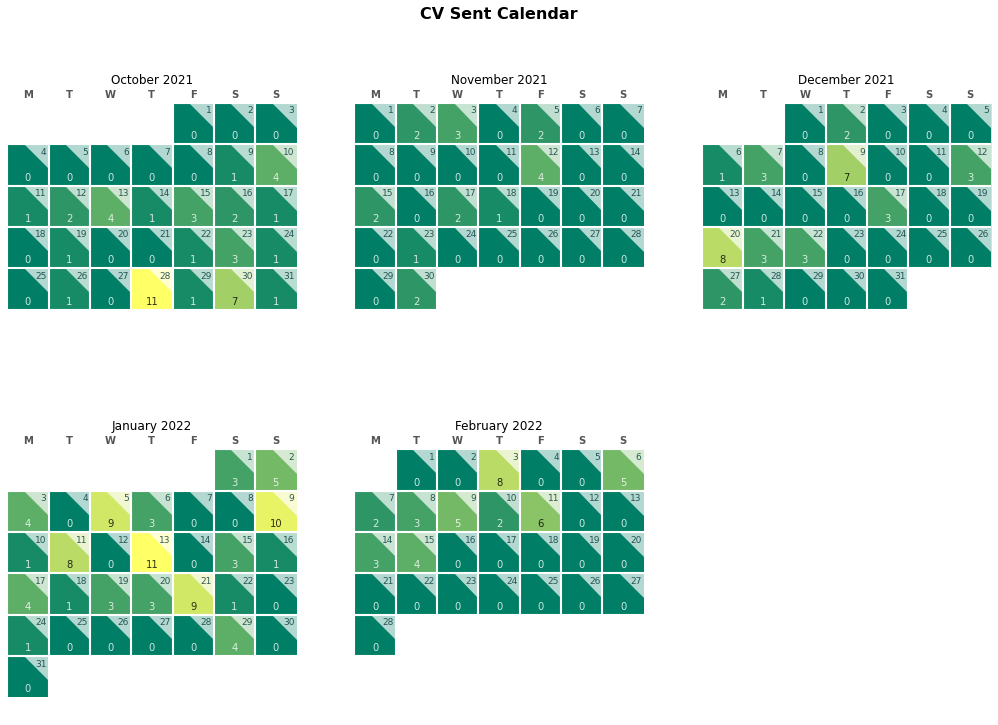

In [11]:
day_nums, day_vals= split_months(cvSentPerDay, 'Day', 'Sent')
fig = create_year_calendar(day_nums, day_vals, title='CV Sent Calendar', format=(2,3), cmap='summer')

plt.savefig('./images/calendar.png')

plt.show(fig)

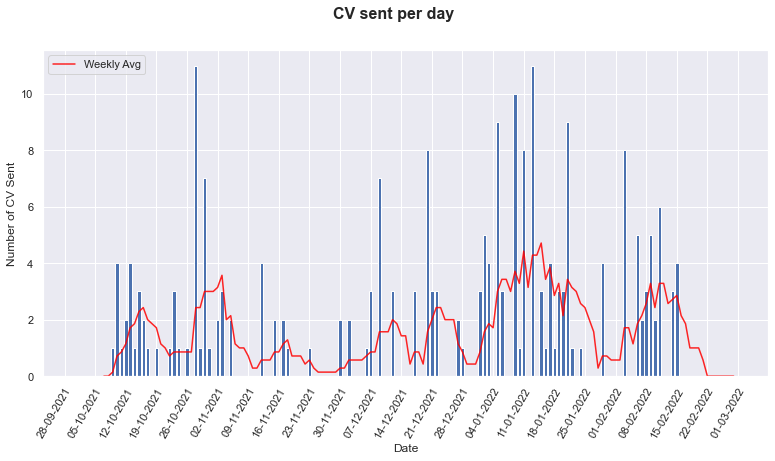

In [12]:
sns.set()

fig, ax = plt.subplots(1, 1, figsize=(13,6))

ax.bar(cvSentPerDay['Day'], cvSentPerDay['Sent'])
ax.plot(cvSentPerDay['Day'], cvSentPerDay['Week Avg'], color='#FF0000', alpha=0.85, label='Weekly Avg')

ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")

fig.suptitle('CV sent per day', fontsize=16, fontweight="bold")
ax.set_xlabel('Date')
ax.set_ylabel('Number of CV Sent')
ax.legend(loc='upper left')

plt.savefig('./images/cv_sent_per_day.png')

plt.show()

#### Time For Reply

In [13]:
data['Delta Time'] = (data['Reply Date'] - data['Day Sent'])
deltaTimes = data['Delta Time'].dt.days.value_counts()

delayDF = pd.DataFrame(
    {
        'Delay':np.arange(
            deltaTimes.index.min(), 
            deltaTimes.index.max() + 1
        ),
        'Count':0,
    }
)

for day in deltaTimes.index:
    delayDF.loc[delayDF['Delay'] == day, 'Count'] = deltaTimes.values[deltaTimes.index == day][0] 

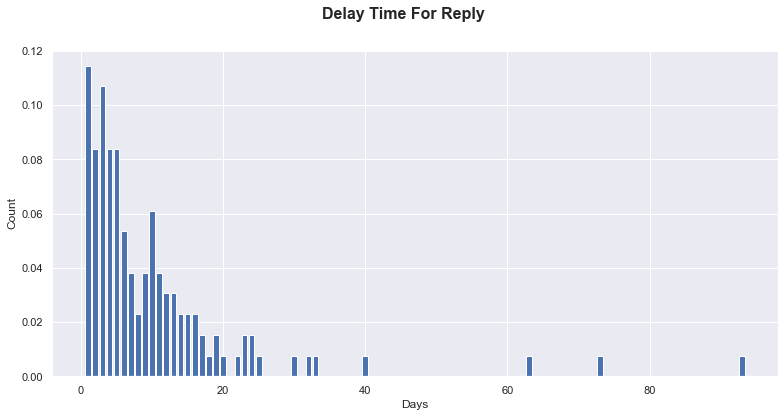

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(13,6))

ax.bar(
    x=delayDF['Delay'],
    height=delayDF['Count']/np.sum(delayDF['Count']), 
)

fig.suptitle('Delay Time For Reply', fontsize=16, fontweight="bold")
ax.set_xlabel('Days')
ax.set_ylabel('Count')

plt.savefig('./images/delay_time_for_reply.png')

plt.show()

## Position

In this section, it will be answered the following questions:

- Which position have I applied to
- Is there any position that it is easier to get an interview

In [15]:
sankeyData = prepSankeyData(data, 'Position')

nodeX = [0,  0.25,  0.25, 0.25, 0.25, 0.25, 0.25,  0.50,  0.50, 0.50,  0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50, 0.50,  0.75,  0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,    1,    1]
nodeY = [0, -0.20,  0.01, 0.20, 0.55, 0.90, 1.05, -0.15, -0.25, 0.05, -0.05, 0.15, 0.25, 0.45, 0.65, 0.85, 0.95, 1.05, -0.15, -0.05, 0.05, 0.15, 0.45, 0.35, 0.55, 0.85, 1.05, 0.55, 1.05]

fig = go.Figure(data=[go.Sankey(
    valueformat = ".0f",
    # Define nodes
    node = dict(
      pad = 15,
      thickness = 15,
      line = dict(color = "black", width = 0.5),
      label = sankeyData['label'],
      color = sankeyData['palette'],
      x = nodeX,
      y = nodeY,
    ),
    # Add links
    link = dict(
      source = sankeyData['source'],
      target = sankeyData['target'],
      value = sankeyData['values'],
      label = sankeyData['label'],
      color = sankeyData['palette'],
))])

fig.update_layout(font_size=10)

fig.write_image('./images/position_sankey.png')

fig.show()